### Neural Style Transfer

Neural Style Transfer (NST) is a technique in computer vision and image processing that uses deep neural networks to apply the style of one image (such as a painting) to the content of another image. The goal is to generate a new image that combines the content of one input image with the artistic style of another.

The process typically involves three key components:

- *Content Image:* The image whose content you want to retain in the final stylized image.

- *Style Image:* The image whose artistic style you want to apply to the content image.

- *Generated (Stylized) Image:* The output image that results from combining the content of the content image with the style of the style image.

The underlying neural network architecture for NST is often based on a pre-trained convolutional neural network (CNN), such as the VGG-19 model. The idea is to use the features learned by the CNN to capture both the content and style of the input images. 

The optimization process involves finding an image that minimizes the content difference between the content image and the generated image, while also minimizing the style difference between the style image and the generated image. This is achieved through iterative optimization techniques, adjusting the pixels of the generated image to match both content and style representations.

### Installing Modules

In [19]:
! pip install torch
! pip install torchvision
! pip install Pillow
! pip install matplotlib
! pip install numpy
! pip install tqdm

<hr>

### Import Modules

In [35]:
import torch 
from torchvision import transforms, models
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

<hr>

### Setting up models

In [36]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

<hr>

### Loading Data and Extracting Features

In [38]:
def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features


In [39]:
transform = transforms.Compose([transforms.Resize(300),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


content = Image.open("content.jpg").convert("RGB")
content = transform(content).to(device)
print("Content shape => ", content.shape)
style = Image.open("style.jpg").convert("RGB")
style = transform(style).to(device)

Content shape =>  torch.Size([3, 300, 300])


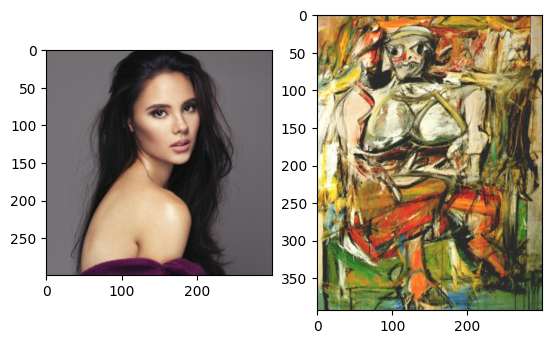

In [40]:
def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x,0,1)

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content),label = "Content")
ax2.imshow(imcnvt(style),label = "Style")
plt.show()

In [41]:
def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    
    return gram_mat

In [42]:
target = content.clone().requires_grad_(True).to(device)

#set device to cuda if available
print("device = ",device)

device =  cpu


In [43]:
style_features = model_activations(style,model)
content_features = model_activations(content,model)

In [44]:
style_wt_meas = {"conv1_1" : 1.0, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

In [45]:
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

content_wt = 100
style_wt = 1e8

print_after = 100
epochs = 500
optimizer = torch.optim.Adam([target],lr=0.007)

<hr>

### Training Model

In [46]:
losses = []
for i in tqdm(range(1,epochs+1)):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
    
    total_loss = content_wt*content_loss + style_wt*style_loss 
    
    losses.append(total_loss.item())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_after == 0:
        plt.imsave(str(i)+'.png',imcnvt(target),format='png')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [15:00<00:00,  1.80s/it]


<hr>

### Example Images

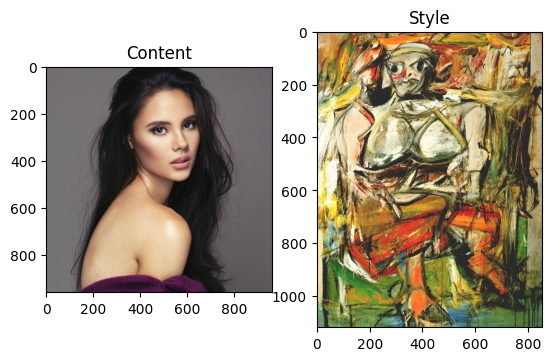

In [54]:
content = Image.open('content.jpg')
style = Image.open('style.jpg')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(content)
ax1.set_title('Content')
ax2.imshow(style)
ax2.set_title('Style')
plt.show()

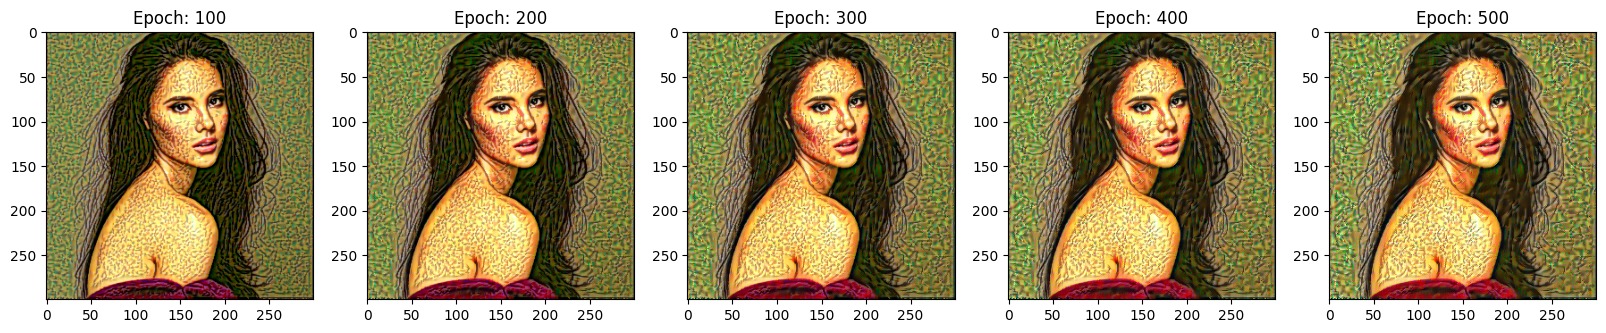

In [63]:
names = [100, 200, 300, 400, 500]
fig, axs = plt.subplots(1, 5, figsize=(20, 60))
for i in range(5):
    axs[i].set_title(f'Epoch: {names[i]}')
    axs[i].imshow(Image.open(f'{names[i]}.png'))
plt.show()

<hr>

### Potential Improvements

- *Fine-tuning Hyperparameters:* Experiment with different hyperparameters such as the learning rate, number of iterations, and the weight of the content and style loss terms. This process may be time consuming.

- *Explore Different Neural Networks:* While VGG-19 is a popular choice for NST, we might want to explore other pre-trained models such as ResNet or Inception. Different architectures may capture features in a way that is more suitable for your specific style transfer task.

- *Add Total Variation Regularization:* We may consider adding a total variation regularization term to the loss function. This helps reduce noise in the generated image and can lead to visually smoother results.

- *Implement Progressive Style Transfer:* Experiment with progressive style transfer, where the stylization is applied gradually over multiple iterations. This can sometimes lead to more visually appealing results.

- *Memory and Speed Optimization:* We might want to optimize the memory usage and speed of the NST system. This is especially important if we plan to deploy the system in real-time applications.

<hr>